## Define constants

In [178]:
TRAIN_DATA_FILE_NAME = "train-images-idx3-ubyte"
TRAIN_LABELS_FILE_NAME = "train-labels-idx1-ubyte"
TEST_DATA_FILE_NAME = "t10k-images-idx3-ubyte"
TEST_LABELS_FILE_NAME = "t10k-labels-idx1-ubyte"

FILES = {
    "train_data": TRAIN_DATA_FILE_NAME,
    "train_labels": TRAIN_LABELS_FILE_NAME,
    "test_data": TEST_DATA_FILE_NAME,
    "test_labels": TEST_LABELS_FILE_NAME
}

MNIST_IMAGE_SIZE = 28
BATCH_SIZE = 24
INITIAL_LEARNING_RATE = 0.0001
LEARNING_ITERATIONS = 10_000

## Download files

In [2]:
for file_name in FILES.values():
    download_command = f"wget -O ../resources/{file_name}.gz https://storage.googleapis.com/cvdf-datasets/mnist/{file_name}.gz"
    !{download_command}
    unzip_command = f"gunzip ../resources/{file_name}.gz"
    !{unzip_command}

--2025-08-17 11:16:04--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.36.187, 142.251.36.219, 142.251.36.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.36.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘../resources/train-images-idx3-ubyte.gz’

../resources/train- 100%[===================>]   9.45M  12.0MB/s    in 0.8s    

2025-08-17 11:16:05 (12.0 MB/s) - ‘../resources/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-08-17 11:16:05--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.36.187, 142.251.36.219, 142.251.36.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.36.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

## Read data into tensors

In [38]:
import torch
import matplotlib.pyplot as plt

In [39]:
def read_data(file_name: str) -> torch.Tensor:
    with open(f"../resources/{file_name}", "rb") as f:
        data: list[torch.Tensor] = []
        f.read(16)
        while True:
            chunk = f.read(784)
            if not chunk:
                break            
            if len(chunk) == 784:
                tensor = torch.tensor(list(chunk), dtype=torch.uint8)
                data.append(tensor)
            else:
                print("End of file reached with an incomplete chunk.")
                break
                
        return torch.stack(data) / 255

In [40]:
def read_labels(file_name: str) -> torch.Tensor:
    with open(f"../resources/{file_name}", "rb") as f:
        labels: list[torch.Tensor] = []
        f.read(8)
        while True:
            chunk = f.read(1)
            if not chunk:
                break            
            if len(chunk) == 1:
                tensor = torch.tensor(list(chunk), dtype=torch.uint8)
                labels.append(tensor)
            else:
                print("End of file reached with an incomplete chunk.")
                break
                
        return torch.stack(labels).long().flatten()

In [179]:
train_data = read_data(FILES["train_data"])
train_labels = read_labels(FILES["train_labels"])

test_data = read_data(FILES["test_data"])
test_labels = read_labels(FILES["test_labels"])

In [180]:
print(f"train data: {train_data.shape}")
print(f"train labels: {train_labels.shape}")
print()
print(f"test data: {test_data.shape}")
print(f"test labels: {test_labels.shape}")

train data: torch.Size([60000, 784])
train labels: torch.Size([60000])

test data: torch.Size([10000, 784])
test labels: torch.Size([10000])


Label: 5


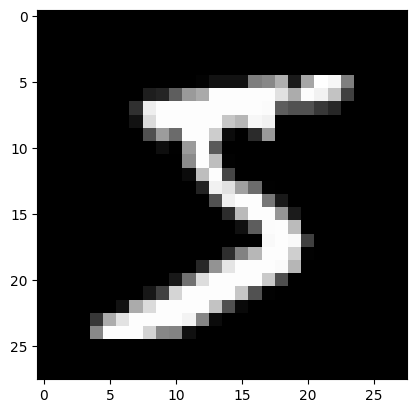

In [181]:
# small validity check whether data is loaded correctly
print(f"Label: {train_labels[0].item()}")
plt.imshow(train_data[0].view(28,28).numpy(), cmap="gray")

In [182]:
import random

def get_batch(data: torch.Tensor, labels: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    num_samples, _ = data.shape
    indices = torch.Tensor([random.randint(0, num_samples -1) for _ in range(BATCH_SIZE)]).int()

    xs = data[indices]
    ys = labels[indices]

    return xs, ys


In [183]:
torch.unique(train_labels).float()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## Thoughts on model

We have 28*28 channels that in the end need to output the logits for 10 distinct numbers. 

So the model must convert an input of 784 numbers to and output of 10 numbers.

In [184]:
import torch.nn as nn
import torch.nn.functional as F

In [185]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 784),
            nn.ReLU(),
            nn.Linear(784, 254),
            nn.ReLU(),
            nn.Linear(254, 10),
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        logits = self.model(x)
        return F.softmax(logits, dim=1)

In [186]:
model = MLP()

In [187]:
loss_function = nn.CrossEntropyLoss()

In [188]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [176]:
@torch.no_grad()
def evaluate():
    predictions = model.predict(test_data)
    predictions = torch.argmax(predictions, dim=1)
    matches = predictions == test_labels
    print(f"{matches.sum().item() * 100 / len(matches)}% correct predictions") 

In [189]:
for i in range(LEARNING_ITERATIONS):
    xs, ys = get_batch(train_data, train_labels)
    optimizer.zero_grad()
    logits = model(xs)
    loss = loss_function(logits, ys)
    if i % 100 == 0:
        evaluate()
    loss.backward()
    optimizer.step()

7.3% correct predictions
88.31% correct predictions
90.59% correct predictions
91.52% correct predictions
93.11% correct predictions
93.84% correct predictions
92.23% correct predictions
93.99% correct predictions
95.19% correct predictions
95.26% correct predictions
94.97% correct predictions
93.84% correct predictions
95.64% correct predictions
95.81% correct predictions
95.7% correct predictions
95.79% correct predictions
95.87% correct predictions
96.57% correct predictions
96.09% correct predictions
95.37% correct predictions
96.75% correct predictions
96.04% correct predictions
96.5% correct predictions
96.0% correct predictions
96.47% correct predictions
95.94% correct predictions
96.77% correct predictions
96.66% correct predictions
96.34% correct predictions
96.1% correct predictions
97.02% correct predictions
96.65% correct predictions
96.75% correct predictions
96.69% correct predictions
96.88% correct predictions
97.34% correct predictions
96.48% correct predictions
97.44% 